# 02. Data Preprocessing - GreenSpace CNN

This notebook handles data preprocessing for the multi-task greenspace CNN:
- Survey response cleaning and label processing  
- Image preprocessing and augmentation setup
- Train/validation/test splits
- Data pipeline creation for TensorFlow/Keras


In [10]:
# Imports
import random
from pathlib import Path
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Seeds to control randomness for repeatable runs
GLOBAL_SEED = 123 # master seed used to sync Python, NumPy, and TensorFlow RNGs
RNG_STATE_SPLIT = 123 # fixed seeds for the two-stage train/val/test split
RNG_STATE_SPLIT_2 = 456 
RNG_STATE_AUG = 123 # seed for shuffle order and augmentation pipeline
'''
With these set, 
shuffles/augs/splits are stable across runs (given the same data).
'''
# Set seeds for libraries
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

# set project root
PROJECT_ROOT = Path(os.environ['PROJECT_ROOT'])  # fails fast if unset


### Step 0A: attach Google Drive `file_id` to `filelist_XXXX.csv`

**How the match works**: we join on the filename (`ImageName` ↔ Drive `name`) after simple normalization (trim + lowercase extension). The join itself is fast; the only potentially slow part is listing the Drive folder once.

Output written to: `data/interim/filelist_<RUN_TAG>_with_drive_fileid.csv` (timestamped per run, where `RUN_TAG = MMDD_HHMMSS`).


In [2]:
# get the file list from the filelist_0103.csv
filelist_path = PROJECT_ROOT / 'data' / 'filelist_0103.csv'


In [ ]:
# Timestamped output name so multiple runs can coexist
from datetime import datetime
RUN_TAG = datetime.now().strftime('%m%d_%H%M%S')  # MMDD_HHMMSS
print('This Run\'s RUN_TAG:', RUN_TAG)

In [12]:
import sys
import pandas as pd

# Ensure `src/` is importable when running from notebooks/
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.drive_utils import get_drive, list_files_in_folder

# Load your filelist (ImageName is the filename we will match)
df_fl = pd.read_csv(filelist_path)
assert 'ImageName' in df_fl.columns, f"Expected ImageName column. Got: {list(df_fl.columns)}"

# Normalize filenames for joining (trim + lowercase extension)
df_fl['image_filename'] = (
    df_fl['ImageName'].astype(str).str.strip()
    .str.replace(r'\.([A-Za-z0-9]+)$', lambda m: f".{m.group(1).lower()}", regex=True)
)

# List Drive folder once to build a manifest (name -> file_id)
FOLDER_ID = os.getenv('GOOGLE_DRIVE_FOLDER_ID')
assert FOLDER_ID, 'Missing GOOGLE_DRIVE_FOLDER_ID in environment/.env'
INCLUDE_SHARED = os.getenv('GOOGLE_DRIVE_INCLUDE_SHARED', 'true').lower() in {'1','true','yes','y'}
MIME_PREFIX = os.getenv('GOOGLE_DRIVE_MIME_PREFIX', 'image/')

drive = get_drive(use_local_server=True)
files = list_files_in_folder(
    drive,
    FOLDER_ID,
    mime_prefix=MIME_PREFIX,
    include_shared_drives=INCLUDE_SHARED,
    limit=None,
)

mf = pd.DataFrame(files)
if mf.empty:
    raise SystemExit('Drive manifest is empty. Check folder ID / permissions / MIME filter.')

mf['image_filename'] = (
    mf['name'].astype(str).str.strip()
    .str.replace(r'\.([A-Za-z0-9]+)$', lambda m: f".{m.group(1).lower()}", regex=True)
)

# Handle duplicate filenames in Drive (keep first, but warn)
dup = mf['image_filename'].duplicated(keep=False)
if dup.any():
    dups = mf.loc[dup, 'image_filename'].value_counts().head(10)
    print('WARNING: duplicate filenames in Drive (showing top 10):')
    print(dups)
    mf = mf.drop_duplicates('image_filename', keep='first')

# Join file_id onto filelist
df_join = df_fl.merge(mf[['image_filename', 'file_id']], on='image_filename', how='left')
df_join = df_join.rename(columns={'file_id': 'drive_file_id'})

missing = int(df_join['drive_file_id'].isna().sum())
print(f"Filelist rows: {len(df_join)} | matched: {len(df_join)-missing} | missing: {missing}")


out_path = PROJECT_ROOT / 'data' / 'interim' / f'filelist_{RUN_TAG}_with_drive_fileid.csv'
out_path.parent.mkdir(parents=True, exist_ok=True)
df_join.to_csv(out_path, index=False)

# Persist the chosen path for downstream cells in this notebook
filelist_with_id = out_path

print('Wrote:', out_path)
print('RUN_TAG:', RUN_TAG)

if missing:
    print('Tip: inspect missing rows by filtering drive_file_id is null and check naming/case.')


Filelist rows: 29161 | matched: 29161 | missing: 0
Wrote: /Users/starsrain/2025_codeProject/GreenSpace_CNN/data/interim/filelist_0129_093401_with_drive_fileid.csv
RUN_TAG: 0129_093401


### Step 1: validate CSV ↔ images

- We compare the set of filenames in the cleaned CSV (`image_filename`) with what exists in `data/raw/images/`.
- If anything is missing or extra, we stop here so downstream steps don’t fail in subtle ways.



In [14]:
# 0B-1) Run cleaner on the new raw survey and write cleaned CSV
import subprocess
import sys

# CHANGE THE FILE NAME WITH NEW SURVEY!!!!!!
RAW_SURVEY = PROJECT_ROOT / 'data' / 'raw' / '0129_survey_response.csv' # CHANGE THIS WITH NEW SURVEY!!!!!!

# Timestamp tag shared across artifacts for this notebook run
from datetime import datetime
RUN_TAG = globals().get('RUN_TAG', None) or datetime.now().strftime('%m%d_%H%M%S')  # MMDD_HHMMSS

# Write cleaned survey to a run-specific filename (so multiple runs can coexist)
CLEAN_SURVEY = PROJECT_ROOT / 'data' / 'raw' / f'survey_response_clean_{RUN_TAG}.csv'

assert RAW_SURVEY.exists(), f"Missing raw survey: {RAW_SURVEY}"

cmd = [
    sys.executable,
    str(PROJECT_ROOT / 'scripts' / 'clean_survey.py'),
    '--in-csv', str(RAW_SURVEY),
    '--out-csv', str(CLEAN_SURVEY),
    '--image-col', 'Image Name',
]
print('RUN_TAG:', RUN_TAG)
print('Running:', ' '.join(cmd))
subprocess.run(cmd, check=True)
print('Wrote cleaned survey:', CLEAN_SURVEY)

# 0B-2) Build training manifest for rated images only (~2300): attach Drive file_id
# Prefer the path produced by Step 0A in this run; otherwise fall back to the newest timestamped file.
filelist_with_id = globals().get('filelist_with_id', None)
if filelist_with_id is None:
    interim_dir = PROJECT_ROOT / 'data' / 'interim'
    candidates = sorted(
        interim_dir.glob('filelist_*_with_drive_fileid.csv'),
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )
    assert candidates, f"No filelist_*_with_drive_fileid.csv found in {interim_dir} (run Step 0A first)"
    filelist_with_id = candidates[0]

filelist_with_id = Path(filelist_with_id)
print('Using filelist_with_id:', filelist_with_id)
assert filelist_with_id.exists(), f"Missing: {filelist_with_id} (run Step 0A first)"

sv = pd.read_csv(CLEAN_SURVEY)
assert 'image_filename' in sv.columns, "Cleaned survey must contain image_filename"

# --- Dashboard: include_tile filtering (required) ---
assert 'include_tile' in sv.columns, (
    "Missing required column 'include_tile' in cleaned survey. "
    "(Did the raw survey change, or did cleaning drop/rename it?)"
)

_before_rows = len(sv)
_before_imgs = sv['image_filename'].astype(str).nunique(dropna=False)

sv = sv[sv['include_tile'].astype(str).str.strip().str.lower().eq('yes')].copy()

_after_rows = len(sv)
_after_imgs = sv['image_filename'].astype(str).nunique(dropna=False)

print('--- include_tile filter (keep yes) ---')
print(f"Before: rows={_before_rows:,} | unique_images={_before_imgs:,}")
print(f"After : rows={_after_rows:,} | unique_images={_after_imgs:,}")

fl = pd.read_csv(filelist_with_id)
assert 'image_filename' in fl.columns and 'drive_file_id' in fl.columns

joined = sv.merge(fl[['image_filename', 'drive_file_id', 'ReviewFlag']], on='image_filename', how='left')
missing = int(joined['drive_file_id'].isna().sum())
print(f"Survey rows (post-filter): {len(joined)} | matched drive_file_id: {len(joined)-missing} | missing: {missing}")

# Write manifest to a run-specific filename (so multiple runs can coexist)
out_path = PROJECT_ROOT / 'data' / 'interim' / f'survey_with_fileid_{RUN_TAG}.csv'
out_path.parent.mkdir(parents=True, exist_ok=True)
joined.to_csv(out_path, index=False)

# Persist the chosen path for downstream cells in this notebook
survey_with_fileid_path = out_path

print('Wrote:', out_path)

if missing:
    miss_names = joined.loc[joined['drive_file_id'].isna(), 'image_filename'].astype(str).unique()[:10]
    print('Missing examples (first 10):')
    print('\n'.join(miss_names))


RUN_TAG: 0129_093401
Running: /Users/starsrain/2025_codeProject/GreenSpace_CNN/.venv/bin/python /Users/starsrain/2025_codeProject/GreenSpace_CNN/scripts/clean_survey.py --in-csv /Users/starsrain/2025_codeProject/GreenSpace_CNN/data/raw/0129_survey_response.csv --out-csv /Users/starsrain/2025_codeProject/GreenSpace_CNN/data/raw/survey_response_clean_0129_093401.csv --image-col Image Name
Wrote /Users/starsrain/2025_codeProject/GreenSpace_CNN/data/raw/survey_response_clean_0129_093401.csv (rows=4122, cols=16)
Wrote cleaned survey: /Users/starsrain/2025_codeProject/GreenSpace_CNN/data/raw/survey_response_clean_0129_093401.csv
Using filelist_with_id: /Users/starsrain/2025_codeProject/GreenSpace_CNN/data/interim/filelist_0129_093401_with_drive_fileid.csv
--- include_tile filter (keep yes) ---
Before: rows=4,122 | unique_images=3,310
After : rows=3,904 | unique_images=3,160
Survey rows (post-filter): 3904 | matched drive_file_id: 3904 | missing: 0
Wrote: /Users/starsrain/2025_codeProject/Gre

### Step 2: aggregate rater labels → soft & hard per image

In [15]:

# Use the cleaned survey produced in Step 0B-1 (this run), or fall back to the newest one on disk.
csv = globals().get('CLEAN_SURVEY', None)
if csv is None:
    raw_dir = Path('../data/raw')
    candidates = sorted(
        raw_dir.glob('survey_response_clean_*.csv'),
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )
    assert candidates, f"No survey_response_clean_*.csv found in {raw_dir} (run Step 0B-1 first)"
    csv = candidates[0]

csv = Path(csv)
print('Using cleaned survey:', csv)

out = Path('../data/processed'); out.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(csv)
key = 'image_filename'  # aggregate to one row per image

# --- Dashboard: include_tile filtering (required) ---
assert 'include_tile' in df.columns, (
    "Missing required column 'include_tile' in cleaned survey. "
    "(Did the raw survey change, or did cleaning drop/rename it?)"
)

_before_rows = len(df)
_before_imgs = df[key].astype(str).nunique(dropna=False)

df = df[df['include_tile'].astype(str).str.strip().str.lower().eq('yes')].copy()

_after_rows = len(df)
_after_imgs = df[key].astype(str).nunique(dropna=False)

print('--- include_tile filter (keep yes) ---')
print(f"Before: rows={_before_rows:,} | unique_images={_before_imgs:,}")
print(f"After : rows={_after_rows:,} | unique_images={_after_imgs:,}")

# ---- Column schema (normalized by scripts/clean_survey.py) ----
# 5-class: structured_unstructured (1..5)
# 5-class: vegetation_cover_distribution (5 categories)
# binary: sports_field, multipurpose_open_area, children_s_playground, water_feature,
#         gardens, walking_paths, built_structures, parking_lots
# 2-class: shade_along_paths (Minimal/Abundant)

binary_cols = [
    'sports_field',
    'multipurpose_open_area',
    'children_s_playground',
    'water_feature',
    'gardens',
    'walking_paths',
    'built_structures',
    'parking_lots',
]

required = ['structured_unstructured', 'vegetation_cover_distribution', 'shade_along_paths', key]
missing_cols = [c for c in (required + binary_cols) if c not in df.columns]
if missing_cols:
    raise SystemExit(f"Missing expected columns in cleaned survey: {missing_cols}")

# ---- Parse binaries ----
yn = {'yes': 1, 'no': 0}
for c in binary_cols:
    df[c] = (
        df[c]
        .astype(str)
        .str.strip()
        .str.lower()
        .map(yn)
        .astype(float)
    )

# ---- Parse shade (2-class) ----
# Values look like: "Minimal (< 10%)" or "Abundant (> 10%)"
shade_first = (
    df['shade_along_paths']
    .astype(str)
    .str.strip()
    .str.lower()
    .str.extract(r'^(minimal|abundant)')[0]
)
shade_map = {'minimal': 0, 'abundant': 1}
df['shade_i'] = shade_first.map(shade_map).astype(float)  # 0/1

# ---- Parse structured_unstructured (1..5) ----
df['score_i'] = pd.to_numeric(
    df['structured_unstructured'].astype(str).str.extract(r'^(\d)')[0],
    errors='coerce'
)

# ---- Parse vegetation_cover_distribution (map to 1..5) ----
veg_norm = (
    df['vegetation_cover_distribution']
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r'\s*\(.*\)$', '', regex=True)  # drop parenthetical
)
veg_map = {
    'only low vegetation': 1,
    'low vegetation with some trees': 2,
    'mixed': 3,
    'trees with some low vegetation': 4,
    'only trees': 5,
}
df['veg_i'] = veg_norm.map(veg_map).astype(float)

# ---- Aggregate per image (soft labels) ----
g = df.groupby(key, dropna=False)
n = g.size().rename('n_ratings')

# Binary soft probabilities
bin_soft = g[binary_cols].mean().astype(float)
bin_soft.columns = [f'{c}_p' for c in binary_cols]

# Shade soft probabilities (minimal/abundant)
shade_probs = g['shade_i'].apply(lambda s: s.value_counts(normalize=True)).unstack(fill_value=0.0)
shade_probs = shade_probs.reindex(columns=[0.0, 1.0], fill_value=0.0).astype(float)
shade_probs.columns = ['shade_p_minimal', 'shade_p_abundant']

# Structured soft probabilities (1..5) + mean
score_probs = g['score_i'].apply(lambda s: s.value_counts(normalize=True)).unstack(fill_value=0.0)
score_probs = score_probs.reindex(columns=[1.0, 2.0, 3.0, 4.0, 5.0], fill_value=0.0).astype(float)
score_probs.columns = [f'score_p_{i}' for i in [1, 2, 3, 4, 5]]
score_mean = g['score_i'].mean().rename('score_mean').astype(float)

# Vegetation soft probabilities (1..5) + mean
veg_probs = g['veg_i'].apply(lambda s: s.value_counts(normalize=True)).unstack(fill_value=0.0)
veg_probs = veg_probs.reindex(columns=[1.0, 2.0, 3.0, 4.0, 5.0], fill_value=0.0).astype(float)
veg_probs.columns = [f'veg_p_{i}' for i in [1, 2, 3, 4, 5]]
veg_mean = g['veg_i'].mean().rename('veg_mean').astype(float)

soft = pd.concat([n, bin_soft, shade_probs, score_probs, score_mean, veg_probs, veg_mean], axis=1).reset_index()
soft.to_csv(out / 'labels_soft.csv', index=False)

# ---- Hard labels ----
hard = soft[[key, 'n_ratings']].copy()
for c in binary_cols:
    hard[c] = soft[f'{c}_p'].fillna(0.0).ge(0.5).astype(int)

# Shade class: 0=minimal, 1=abundant
shade_cols = ['shade_p_minimal', 'shade_p_abundant']
shade_arr = soft[shade_cols].fillna(0.0).to_numpy(dtype=float)
hard['shade_class'] = shade_arr.argmax(axis=1)

# Structured class: 1..5
score_cols = [f'score_p_{i}' for i in [1, 2, 3, 4, 5]]
score_arr = soft[score_cols].fillna(0.0).to_numpy(dtype=float)
hard['score_class'] = score_arr.argmax(axis=1) + 1

# Vegetation class: 1..5
veg_cols = [f'veg_p_{i}' for i in [1, 2, 3, 4, 5]]
veg_arr = soft[veg_cols].fillna(0.0).to_numpy(dtype=float)
hard['veg_class'] = veg_arr.argmax(axis=1) + 1

hard.to_csv(out / 'labels_hard.csv', index=False)

print('Wrote:', out/'labels_soft.csv')
print('Wrote:', out/'labels_hard.csv')


Using cleaned survey: /Users/starsrain/2025_codeProject/GreenSpace_CNN/data/raw/survey_response_clean_0129_093401.csv
--- include_tile filter (keep yes) ---
Before: rows=4,122 | unique_images=3,310
After : rows=3,904 | unique_images=3,160
Wrote: ../data/processed/labels_soft.csv
Wrote: ../data/processed/labels_hard.csv


### Step 2A: download/cache rated images from Google Drive (no augmentation)

This downloads only the **rated** images referenced in `data/interim/survey_with_fileid.csv` (≈2142) using `drive_file_id` and saves them locally for fast training.

- Output folder: `data/cache/images/`
- Re-runnable: skips files that already exist
- Supports `TEST_MODE=true` + `TEST_LIMIT=N` from your `.env`


In [16]:
# before re-run the chunk, reload the env to get the latest variable status.

from dotenv import load_dotenv
load_dotenv(PROJECT_ROOT / ".env", override=True)
print("TEST_MODE now =", os.getenv("TEST_MODE"))


TEST_MODE now = false


In [17]:
import os
import sys
import time
from pathlib import Path

import pandas as pd
from tqdm import tqdm

# Ensure src/ is importable
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.drive_utils import get_drive, download_file_bytes

# Use the manifest produced in Step 0B-2 (this run), or fall back to the newest one on disk.
manifest_path = globals().get('survey_with_fileid_path', None)
if manifest_path is None:
    interim_dir = PROJECT_ROOT / 'data' / 'interim'
    candidates = sorted(
        interim_dir.glob('survey_with_fileid_*.csv'),
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )
    assert candidates, f"No survey_with_fileid_*.csv found in {interim_dir} (run Step 0B first)"
    manifest_path = candidates[0]

manifest_path = Path(manifest_path)
print('Using manifest_path:', manifest_path)
assert manifest_path.exists(), f"Missing {manifest_path} (run Step 0B first)"

cache_dir = PROJECT_ROOT / 'data' / 'cache' / 'images'
cache_dir.mkdir(parents=True, exist_ok=True)

m = pd.read_csv(manifest_path)
assert {'image_filename', 'drive_file_id'}.issubset(m.columns), f"Expected columns not found in {manifest_path}"

# Use unique images (one download per image)
m_u = m[['image_filename', 'drive_file_id']].dropna().drop_duplicates('image_filename').copy()

# Optional test limiter from env
TEST_MODE = os.getenv('TEST_MODE', 'false').lower() in {'1','true','yes','y'}
TEST_LIMIT = int(os.getenv('TEST_LIMIT', '200'))
if TEST_MODE:
    m_u = m_u.head(TEST_LIMIT)
    print(f"TEST_MODE on: limiting downloads to {len(m_u)} images")

# Download
MAX_RETRIES = 3
SLEEP_SEC = 1.0

drive = get_drive(use_local_server=True)

n_total = len(m_u)
skipped = 0
failed = 0

for _, row in tqdm(m_u.iterrows(), total=n_total):
    fname = str(row['image_filename'])
    file_id = str(row['drive_file_id'])
    out_path = cache_dir / fname

    if out_path.exists() and out_path.stat().st_size > 0:
        skipped += 1
        continue

    ok = False
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            raw = download_file_bytes(drive, file_id)
            out_path.write_bytes(raw)
            ok = True
            break
        except Exception as e:
            if attempt == MAX_RETRIES:
                failed += 1
                print(f"FAILED: {fname} (id={file_id}) -> {e}")
            else:
                time.sleep(SLEEP_SEC * attempt)

print(f"Cache complete. total={n_total} skipped_existing={skipped} failed={failed}")
print(f"Cache dir: {cache_dir}")



Using manifest_path: /Users/starsrain/2025_codeProject/GreenSpace_CNN/data/interim/survey_with_fileid_0129_093401.csv


100%|██████████| 3160/3160 [27:33<00:00,  1.91it/s]  

Cache complete. total=3160 skipped_existing=1895 failed=0
Cache dir: /Users/starsrain/2025_codeProject/GreenSpace_CNN/data/cache/images


### Step 3: label prevalence (from soft labels)

Images with aggregated labels: 3160

Binary prevalence (soft mean prob) and expected positives:
                          prevalence  expected_positives
gardens_p                      0.033               105.4
children_s_playground_p        0.112               354.8
water_feature_p                0.192               606.5
sports_field_p                 0.267               844.6
parking_lots_p                 0.282               890.9
built_structures_p             0.402              1270.2
walking_paths_p                0.727              2296.1
multipurpose_open_area_p       0.771              2437.4

Rare-ish binaries (<=10% prevalence):
           prevalence  expected_positives
gardens_p       0.033               105.4

Shade distribution (soft):
           prob
minimal   0.662
abundant  0.338

Structured–Unstructured distribution (soft):
          prob
score_1  0.190
score_2  0.199
score_3  0.203
score_4  0.198
score_5  0.209
Mean structured score: 3.038 ± 1.390

Vegetation distrib

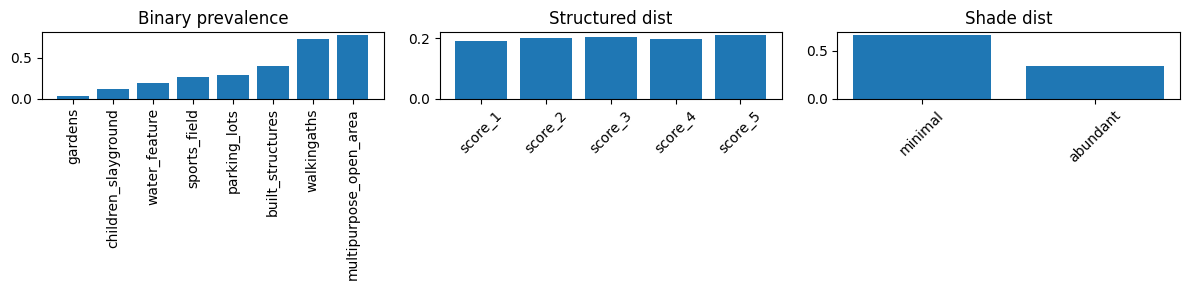

Saved text summary to /Users/starsrain/2025_codeProject/GreenSpace_CNN/monitoring_output/label_prevalence_summary_0129_093401.txt


In [19]:

# Updated prevalence + distribution check (useful for deciding oversampling/augmentation later)
soft_path = Path('../data/processed/labels_soft.csv')
hard_path = Path('../data/processed/labels_hard.csv')
assert soft_path.exists(), f'Missing {soft_path}. Run Step 2 first.'

soft = pd.read_csv(soft_path)
hard = pd.read_csv(hard_path) if hard_path.exists() else None

N = len(soft)
print(f'Images with aggregated labels: {N}')

# ---- Binary prevalence ----
binary_p_cols = [
    c for c in soft.columns
    if c.endswith('_p') and not c.startswith(('shade_p_', 'score_p_', 'veg_p_'))
]
if binary_p_cols:
    bin_prev = soft[binary_p_cols].mean(numeric_only=True).sort_values()
    bin_tbl = (
        bin_prev.rename('prevalence')
        .to_frame()
        .assign(expected_positives=lambda d: (d['prevalence'] * N).round(1))
    )
    print('\nBinary prevalence (soft mean prob) and expected positives:')
    print(bin_tbl.round(3))

    rare = bin_tbl[bin_tbl['prevalence'] <= 0.10]
    if len(rare):
        print('\nRare-ish binaries (<=10% prevalence):')
        print(rare.round(3))

# ---- Shade distribution ----
shade_cols = [c for c in soft.columns if c.startswith('shade_p_')]
if shade_cols:
    shade_prev = soft[shade_cols].mean(numeric_only=True)
    shade_prev.index = [c.replace('shade_p_', '') for c in shade_prev.index]
    print('\nShade distribution (soft):')
    print(shade_prev.to_frame('prob').round(3))

# ---- Structured distribution + mean ----
score_cols = [c for c in soft.columns if c.startswith('score_p_')]
if score_cols:
    score_prev = soft[score_cols].mean(numeric_only=True)
    score_prev.index = [c.replace('score_p_', 'score_') for c in score_prev.index]
    print('\nStructured–Unstructured distribution (soft):')
    print(score_prev.to_frame('prob').round(3))
    if 'score_mean' in soft.columns:
        print(f"Mean structured score: {soft['score_mean'].mean():.3f} ± {soft['score_mean'].std():.3f}")

# ---- Vegetation distribution + mean ----
veg_cols = [c for c in soft.columns if c.startswith('veg_p_')]
if veg_cols:
    veg_prev = soft[veg_cols].mean(numeric_only=True)
    veg_prev.index = [c.replace('veg_p_', 'veg_') for c in veg_prev.index]
    print('\nVegetation distribution (soft):')
    print(veg_prev.to_frame('prob').round(3))
    if 'veg_mean' in soft.columns:
        print(f"Mean vegetation score: {soft['veg_mean'].mean():.3f} ± {soft['veg_mean'].std():.3f}")

# ---- Ratings per image ----
if 'n_ratings' in soft.columns:
    print('\nNumber of ratings per image:')
    print(soft['n_ratings'].describe().to_string())

# ---- Optional quick hard-label counts (sanity) ----
if hard is not None:
    hard_bin = [c for c in hard.columns if c in [p[:-2] for p in binary_p_cols]]
    if hard_bin:
        counts = hard[hard_bin].sum().sort_values()
        print('\nHard positive counts (>=0.5 threshold):')
        print(counts.to_frame('positives'))

try:
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    if binary_p_cols:
        axes[0].bar([c.replace('_p','') for c in bin_prev.index], bin_prev.values)
        axes[0].set_title('Binary prevalence')
        axes[0].tick_params(axis='x', rotation=90)
    if score_cols:
        axes[1].bar(score_prev.index, score_prev.values)
        axes[1].set_title('Structured dist')
        axes[1].tick_params(axis='x', rotation=45)
    if shade_cols:
        axes[2].bar(shade_prev.index, shade_prev.values)
        axes[2].set_title('Shade dist')
        axes[2].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Plotting skipped:', e)

# ---- Save text summary (for reports) ----
from datetime import datetime

out_dir = Path('../monitoring_output').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

tag = globals().get('RUN_TAG', None) or datetime.now().strftime('%Y%m%d_%H%M%S')
out_path = out_dir / f"label_prevalence_summary_{tag}.txt"

lines = []
lines.append(f"Images with aggregated labels: {N}\n")

if binary_p_cols:
    lines.append("Binary prevalence (soft mean prob) and expected positives:\n")
    lines.append(bin_tbl.round(3).to_string())
    lines.append("\n\n")
    if 'rare' in globals() and len(rare):
        lines.append("Rare-ish binaries (<=10% prevalence):\n")
        lines.append(rare.round(3).to_string())
        lines.append("\n\n")

if shade_cols:
    lines.append("Shade distribution (soft):\n")
    lines.append(shade_prev.to_frame('prob').round(3).to_string())
    lines.append("\n\n")

if score_cols:
    lines.append("Structured–Unstructured distribution (soft):\n")
    lines.append(score_prev.to_frame('prob').round(3).to_string())
    lines.append("\n")
    if 'score_mean' in soft.columns:
        lines.append(f"Mean structured score: {soft['score_mean'].mean():.3f} ± {soft['score_mean'].std():.3f}\n")
    lines.append("\n")

if veg_cols:
    lines.append("Vegetation distribution (soft):\n")
    lines.append(veg_prev.to_frame('prob').round(3).to_string())
    lines.append("\n")
    if 'veg_mean' in soft.columns:
        lines.append(f"Mean vegetation score: {soft['veg_mean'].mean():.3f} ± {soft['veg_mean'].std():.3f}\n")
    lines.append("\n")

if 'n_ratings' in soft.columns:
    lines.append("Number of ratings per image:\n")
    lines.append(soft['n_ratings'].describe().to_string())
    lines.append("\n\n")

if hard is not None:
    hard_bin = [c for c in hard.columns if c in [p[:-2] for p in binary_p_cols]]
    if hard_bin:
        counts = hard[hard_bin].sum().sort_values()
        lines.append("Hard positive counts (>=0.5 threshold):\n")
        lines.append(counts.to_frame('positives').to_string())
        lines.append("\n")

out_path.write_text(''.join(lines))
print('Saved text summary to', out_path)


## Augmentation Ideas

- Geometric: horizontal/vertical flips, 90° rotations, random crop→resize (90–100% area), small translate (±5%).
- Photometric: brightness/contrast ±10% (keep mild since “shade” is label-like). Avoid heavy color/hue.

### (Preview) Step 4: oversampling-based augmentation

We no longer use oversampling in the main pipeline now that we have a larger labeled set.
Training-time augmentation is applied in `03_model_training.ipynb` (geometry-only: flips + 90° rotations).

In [ ]:
# Augmentation preview (geometry-only): apply to 5–10 sample images and save to data/interim/aug_preview
# This is just a visual sanity check; training-time augmentation is applied in 03_model_training.ipynb.

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

hard_p = Path('../data/processed/labels_hard.csv')
assert hard_p.exists(), f"Missing: {hard_p} (run Step 2 first)"
dh = pd.read_csv(hard_p)

# Prefer cached images; fall back to raw/images
img_dir = Path('../data/cache/images')
if not img_dir.exists():
    img_dir = Path('../data/raw/images')

out_dir = Path('../data/interim/aug_preview')
out_dir.mkdir(parents=True, exist_ok=True)

N_PREVIEW = 10

# Pick sample images from current label batch
candidates = []
for fn in dh['image_filename'].astype(str).dropna().sample(frac=1.0, random_state=123).tolist():
    p = img_dir / fn
    if p.exists():
        candidates.append(str(p))
    if len(candidates) >= N_PREVIEW:
        break

print(f"Using {len(candidates)} images from {img_dir}")

# Decode + augment

def decode_np(path: str):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

def augment_geom_np(img_np):
    img = tf.convert_to_tensor(img_np, dtype=tf.float32)
    k = tf.random.uniform((), 0, 4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img.numpy()

for path in candidates:
    orig = decode_np(path)
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes[0].imshow(orig); axes[0].set_title('Original'); axes[0].axis('off')
    for i in range(1, 4):
        axes[i].imshow(augment_geom_np(orig)); axes[i].set_title(f'Aug {i}'); axes[i].axis('off')
    plt.tight_layout()
    out_path = out_dir / (Path(path).stem + '_aug_preview.png')
    plt.savefig(out_path, dpi=120, bbox_inches='tight')
    plt.show()
    print('Saved:', out_path)


## Train-test split after augmentation

### Step 5: dynamic 60/20/20 split → train/val/test manifests

In [20]:
from sklearn.model_selection import train_test_split

soft_csv = Path('../data/processed/labels_soft.csv')
hard_csv = Path('../data/processed/labels_hard.csv')
# UPDATED: images are cached here (downloaded from Drive)
img_dir = Path('../data/cache/images')
out_dir = Path('../data/processed/splits'); out_dir.mkdir(parents=True, exist_ok=True)

soft = pd.read_csv(soft_csv)
hard = pd.read_csv(hard_csv)

# Merge soft and hard; keep one row per image
df = hard.merge(soft, on=['image_filename','n_ratings'], how='inner')

# Optional: attach drive_file_id into the split manifests
# Prefer the path produced by Step 0A in this run; otherwise fall back to the newest timestamped file.
filelist_with_id = globals().get('filelist_with_id', None)
if filelist_with_id is None:
    interim_dir = Path('../data/interim')
    candidates = sorted(
        interim_dir.glob('filelist_*_with_drive_fileid.csv'),
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )
    filelist_with_id = candidates[0] if candidates else None

if filelist_with_id is not None:
    filelist_with_id = Path(filelist_with_id)
    if filelist_with_id.exists():
        fl = pd.read_csv(filelist_with_id)
        if {'image_filename', 'drive_file_id'}.issubset(fl.columns):
            df = df.merge(fl[['image_filename', 'drive_file_id']], on='image_filename', how='left')

# Build absolute image_path pointing to cached files
cache_paths = df['image_filename'].apply(lambda x: str((img_dir / x).resolve()))
df['image_path'] = cache_paths

# IMPORTANT: if cache is partial, drop rows whose image isn't downloaded yet
exists_mask = df['image_path'].apply(lambda p: Path(p).exists())
missing_n = int((~exists_mask).sum())
if missing_n:
    print(f"NOTE: cache missing {missing_n} images; filtering to cached-only for now.")
    df = df.loc[exists_mask].copy()

print(f"Using {len(df)} images for splits (cache_dir={img_dir.resolve()})")

# Identify columns to keep
prob_cols = [c for c in df.columns if c.endswith('_p')]  # includes binary_p, shade_p_*, score_p_*, veg_p_*
mean_cols = [c for c in ['score_mean', 'veg_mean'] if c in df.columns]

hard_bin_cols = [
    c for c in [
        'sports_field',
        'multipurpose_open_area',
        'children_s_playground',
        'water_feature',
        'gardens',
        'walking_paths',
        'built_structures',
        'parking_lots',
    ] if c in df.columns
]
other_hard_cols = [c for c in ['shade_class', 'score_class', 'veg_class'] if c in df.columns]

keep_cols = ['image_path', 'image_filename', 'n_ratings']
if 'drive_file_id' in df.columns:
    keep_cols.append('drive_file_id')
keep_cols += prob_cols + mean_cols + hard_bin_cols + other_hard_cols

# Split sizes (no rare-label logic / no stratification for now)
N = len(df)
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
train_size = max(1, round(train_ratio * N))
val_size = max(1, round(val_ratio * N))
test_size = max(1, N - train_size - val_size)
if train_size + val_size + test_size != N:
    test_size = N - train_size - val_size

train_df, temp_df = train_test_split(
    df,
    train_size=train_size,
    random_state=RNG_STATE_SPLIT,
    shuffle=True,
)

val_prop = val_size / max(1, len(temp_df))
val_df, test_df = train_test_split(
    temp_df,
    test_size=(1 - val_prop),
    random_state=RNG_STATE_SPLIT_2,
    shuffle=True,
)

train_df[keep_cols].to_csv(out_dir / 'train.csv', index=False)
val_df[keep_cols].to_csv(out_dir / 'val.csv', index=False)
test_df[keep_cols].to_csv(out_dir / 'test.csv', index=False)

print('Split sizes:', len(train_df), len(val_df), len(test_df))
print('Wrote:', out_dir / 'train.csv')


Using 3160 images for splits (cache_dir=/Users/starsrain/2025_codeProject/GreenSpace_CNN/data/cache/images)
Split sizes: 1896 632 632
Wrote: ../data/processed/splits/train.csv
